In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

In [ ]:
mlflow.get_tracking_uri()

In [3]:
# Dataset de diabetes
dataset = load_diabetes()

In [4]:
# Rapido split
X = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Definición de Esquema de Entrada/Salida en MLflow

En MLflow, es fundamental definir esquemas de entrada y salida para garantizar que los datos manejados por el modelo son consistentes y están en el formato esperado. Estos esquemas se visualizan en la interfaz de usuario de MLflow, facilitando la gestión y comprensión de los modelos.

### Pasos para Definir Esquemas en MLflow

1. **Desactivar Auto-guardado del Modelo:** Al guardar el modelo, usa `log_models=False` para desactivar el auto-guardado y permitir la especificación manual de esquemas.

2. **Definir el Esquema de Entrada:** 
   - Utiliza `Schema([])` para crear un esquema.
   - Incluye cada característica esperada por el modelo con su tipo de dato correspondiente (`double` en este ejemplo).
   - Ejemplo: 
     ```python
     input_schema = Schema([
       ColSpec("double", "age"),
       ColSpec("double", "sex"),
       ColSpec("double", "bmi"),
       ColSpec("double", "bp"),
       // Continúa con las demás características
     ])
     ```

3. **Definir el Esquema de Salida:**
   - Define el formato y tipo de dato de la salida del modelo.
   - Ejemplo:
     ```python
     output_schema = Schema([ColSpec("long", "objetivo")])
     ```

4. **Crear la Firma del Modelo:**
   - Combina los esquemas de entrada y salida.
   - Ejemplo:
     ```python
     signature = ModelSignature(inputs=input_schema, outputs=output_schema)
     ```

### Importancia

- **Validación de Datos:** Asegura que los datos de entrada y salida sean consistentes con lo esperado por el modelo.
- **Facilita la Integración:** Los esquemas claros ayudan a integrar el modelo en sistemas de producción.
- **Mejora la Fiabilidad:** Previene errores y mejora la confiabilidad del modelo.

Con estos pasos, se puede establecer un proceso claro y estructurado para la definición de esquemas en modelos de MLflow, esencial para el manejo efectivo del ciclo de vida de modelos de machine learning.


In [5]:
input_schema = Schema([
  ColSpec("double", "age"),
  ColSpec("double", "sex"),
  ColSpec("double", "bmi"),
  ColSpec("double", "bp"),
  ColSpec("double", "s1"),
  ColSpec("double", "s2"),
  ColSpec("double", "s3"),
  ColSpec("double", "s4"),
  ColSpec("double", "s5"),
  ColSpec("double", "s6"),
])

output_schema = Schema([ColSpec("long", "target")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

2024/02/24 17:40:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
c:\Users\ssill\OneDrive\Escritorio\Sergio\the valley\tm-mlops-workshop\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


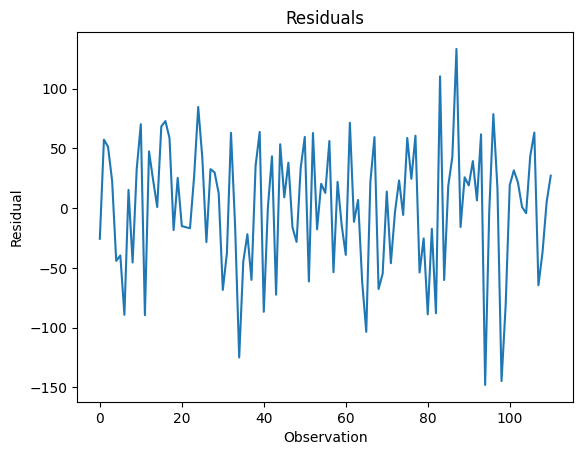

In [6]:
# La forma recomendada de comenzar a usar el seguimiento de MLflow con Python es usar la API autolog() de MLflow.
# Con las capacidades de autologging de MLflow, una sola línea de código registra automáticamente el modelo resultante,
# los parámetros utilizados para crear el modelo y una puntuación del modelo.
mlflow.sklearn.autolog(log_models=False)

# Esta vez usaremos un experimento específico
# Si usas Databricks, el nombre debe ser una ruta de sistema de archivos, así que usa un / antes del nombre
mlflow.set_experiment("Experimento ML de Diabetes")

# Con autolog() activado, todos los parámetros del modelo, una puntuación del modelo y el modelo ajustado se registran automáticamente.
# También es posible pasar un nombre de ejecución como mlflow.start_run(run_name="Mi ejecución increíble"), de lo contrario MLflow elegirá uno por nosotros.
with mlflow.start_run():
  # Establece los parámetros del modelo.
  n_estimators = 10
  max_depth = 5
  max_features = 3

  # Crea y entrena el modelo.
  rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train)

  # Usa el modelo para hacer predicciones en el conjunto de datos de prueba.
  predictions = rf.predict(X_test)

  # Registra los parámetros del modelo utilizados en esta ejecución.
  mlflow.log_param("num_trees", n_estimators)
  mlflow.log_param("maxdepth", max_depth)
  mlflow.log_param("max_feat", max_features)

  # Define una métrica para evaluar el modelo.
  mse = mean_squared_error(y_test, predictions)
    
  # Registra el valor de la métrica de esta ejecución.
  mlflow.log_metric("mse", mse)

  # Incluso podemos registrar explícitamente el modelo creado en esta ejecución con su firma
  mlflow.sklearn.log_model(rf, "model", signature=signature)

  # Convierte los residuales en un dataframe de pandas para aprovechar las capacidades gráficas
  df = pd.DataFrame(data = predictions - y_test)
  # Crea un gráfico de residuales
  plt.plot(df)
  plt.xlabel("Observation")
  plt.ylabel("Residual")
  plt.title("Residuals")

  # Guarda la figura del gráfico
  fig = plt.gcf()
  mlflow.log_figure(fig, "residuals_plot.png")

mlflow.end_run()


In [ ]:
# Despliega el modelo entrenado en un experimiento en local
# cambia el run-id
!mlflow models serve --env-manager=local -m runs:/<run-id>/model -p 5001